# <font color='red'>Definitions</font>

In [1]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [2]:
def vector_to_hermitian(upper_triangle_vector):
    # Check if the input vector is real-valued or complex-valued
    is_real = np.isrealobj(upper_triangle_vector)
    
    # Determine the size of the matrix (n x n)
    n = int(np.sqrt(2 * len(upper_triangle_vector) + 0.25) - 0.5)
    
    # Initialize an empty matrix with the appropriate type
    dtype = float if is_real else complex
    A = np.zeros((n, n), dtype=dtype)
    
    # Fill in the upper triangle
    indices = np.triu_indices(n)
    A[indices] = upper_triangle_vector
    
    # Assign values to the lower triangle
    i_lower = np.tril_indices(n, -1)
    if is_real:
        A[i_lower] = A.T[i_lower]  # Copy upper triangle values to lower triangle
    else:
        A[i_lower] = np.conj(A.T[i_lower])  # Assign conjugate transpose to lower triangle
    
    return A

# <font color='red'>Boson with $U/t = 10$</font>

## <font color='blue'>Parameters</font>

In [67]:
L = 64
N = 64
t = 1.0
U = 10.0
nmax = 5

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

## <font color='blue'>Local operators</font>

In [68]:
# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

basis = [(Q(i), 1) for i in range(nmax + 1)]

bdag = np.diag([np.sqrt(n+1) for n in range(nmax)], -1)
b = bdag.T
ops = {
    "": np.identity(nmax + 1), 
    "c": bdag, 
    "d": b
}

#proj_keys = ["P"+str(n) for n in range(nmax+1)]
proj_keys = ["Q","R","S","T","U","V","W","X","Y"][:nmax+1]
proj_ops = []
for n in range(nmax+1):
    proj_diag = np.diag(np.repeat([0, 1., 0], [n, 1, nmax-n]))
    proj_ops.append(proj_diag)
proj_dict = {}
for n in range(nmax+1):
    proj_dict[proj_keys[n]] = proj_ops[n]

for k in range(L): 
    site_basis.append(basis)
    site_ops.append(ops | proj_dict)

## <font color='blue'>Hamiltonian</font>

In [69]:
# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0), target=Q(N), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
os = driver.expr_builder()

for i in range(L-1):
    os.add_term("cd", [i, i+1], -t)
    os.add_term("cd", [i+1, i], -t)
for i in range(L):
    os.add_term("ccdd", [i, i, i, i], U/2)

# [Part C] Perform DMRG
mpo = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)

## <font color='blue'>DMRG</font>

In [93]:
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=1, occs=[1] * L)
energy = driver.dmrg(
    mpo, 
    mps, 
    n_sweeps=100, 
    bond_dims=[50] * 10 + [100] * 5 + [200] * 5, # + [500] * 5 + [1000] * 5, 
    noises=[1e-3] * 3 + [1e-5] * 3 + [0],  
    thrds=[1e-10] * 20, 
    dav_max_iter=100, 
    tol=1e-10, 
    iprint=1)
print("Final bond dimension =", mps.info.get_max_bond_dimension())


Sweep =    0 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      0.437 | E =       3.9137047594 | DW = 1.91905e-12

Sweep =    1 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      1.662 | E =      -9.3075880086 | DE = -1.32e+01 | DW = 1.86673e-10

Sweep =    2 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      3.545 | E =     -15.3274574697 | DE = -6.02e+00 | DW = 4.79446e-10

Sweep =    3 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      4.382 | E =     -24.8269937786 | DE = -9.50e+00 | DW = 1.78132e-11

Sweep =    4 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      4.682 | E =     -24.9178072681 | DE = -9.08e-02 | DW = 2.32565e-15

Sweep =    5 | Direction = backward 

## <font color='blue'>Evolution over sweeps</font>

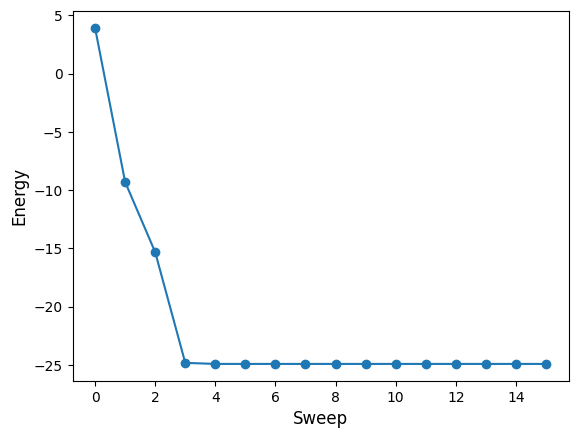

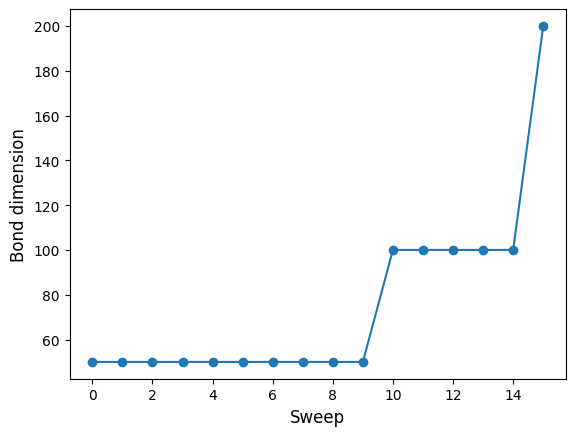

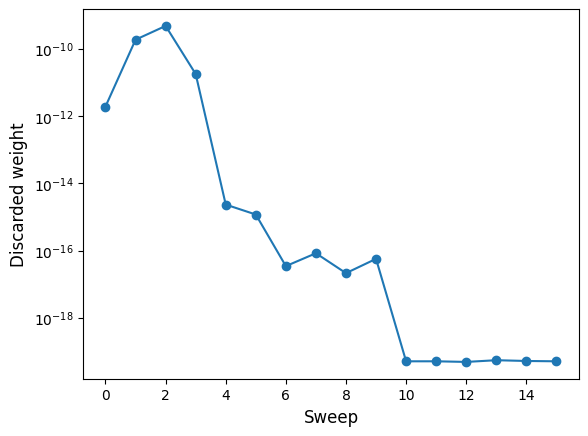

In [95]:
bonddims, discardedweights, energies = driver.get_dmrg_results()
plt.plot(energies.flatten(), marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.show()
plt.plot(bonddims, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Bond dimension', fontsize=12)
plt.show()
plt.plot(discardedweights, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Discarded weight', fontsize=12)
plt.yscale('log')
plt.show()

## <font color='blue'>Entanglement</font>

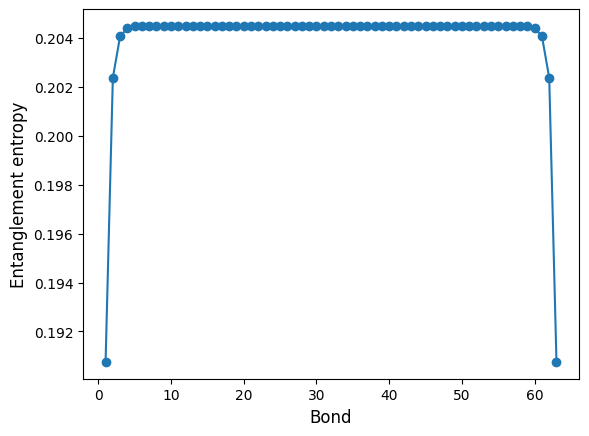

In [96]:
SvN = driver.get_bipartite_entanglement()

plt.plot(np.arange(1,L), SvN, marker='o')
plt.xlabel('Bond', fontsize=12)
plt.ylabel('Entanglement entropy', fontsize=12)
plt.show()

## <font color='blue'>Single-particle boson correlations</font>

### Calculate

In [97]:
start_time = time.time()

bosoncorr = []
for i in range(L):
    for j in range(i,L):
        os = driver.expr_builder().add_term("cd", [i, j], 1)
        op = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""))
        opexp = driver.expectation(mps, op, mps)
        bosoncorr.append(opexp)
bosoncorr_mat = vector_to_hermitian(bosoncorr)
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Total number = 64.00000000000061
Elapsed time: 71.82275104522705 seconds


### Site occupations

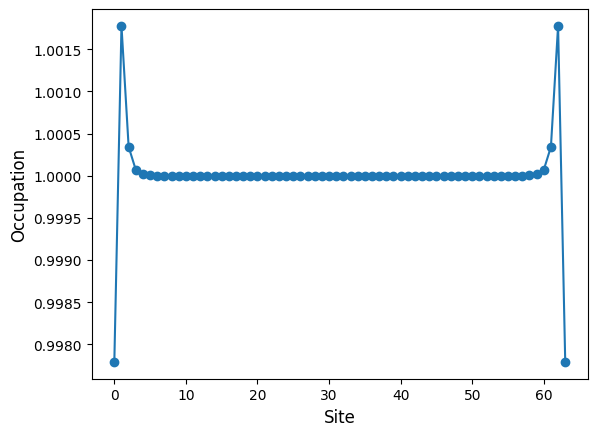

In [98]:
plt.plot(np.arange(L), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

### Correlation matrix

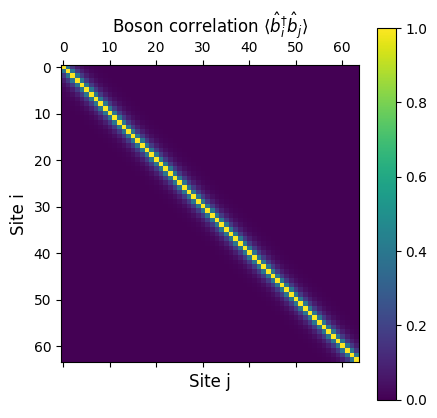

In [99]:
plt.matshow(bosoncorr_mat, cmap='viridis', vmin=bosoncorr_mat.min(), vmax=bosoncorr_mat.max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

### Correlation vs distance

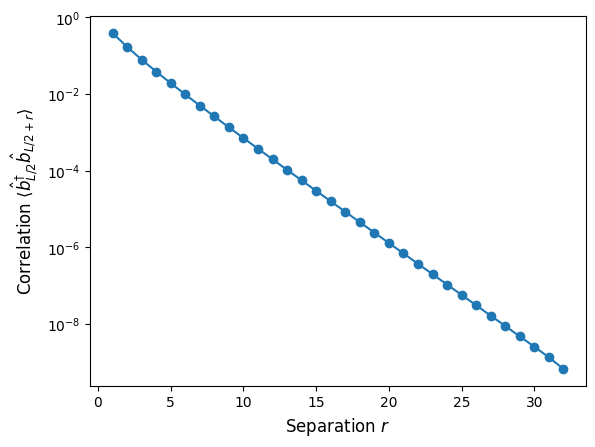

In [100]:
plt.plot(np.arange(1,L//2+1), bosoncorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()

### Momentum distribution

Total number = 64.00000000000065


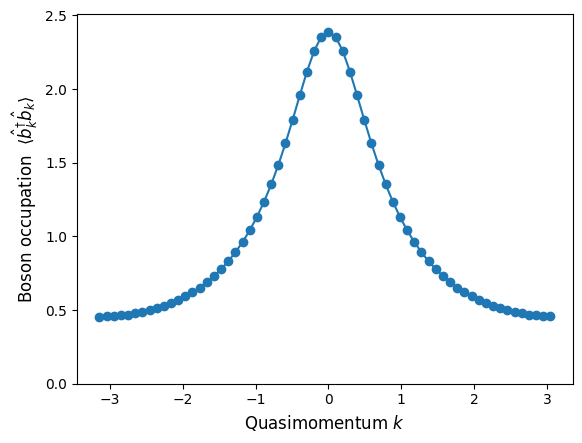

In [101]:
klist = (2*np.pi/L)*np.arange(-L//2,L//2)
fourier = np.array([[np.exp(1j*k*j) for j in np.arange(L)] for k in klist])
fourier_inverse = fourier.conj().T
boson_momentum_corr = np.dot(np.dot(fourier, bosoncorr_mat), fourier_inverse)/L
boson_momentum_dist = np.real(np.diag(boson_momentum_corr))
print("Total number =", sum(boson_momentum_dist))

plt.plot(klist, boson_momentum_dist, marker='o')
plt.xlabel('Quasimomentum $k$', fontsize=12)
plt.ylabel(r'Boson occupation  $\langle \hat{b}_k^{\dagger} \hat{b}_k \rangle$', fontsize=12)
plt.yscale('linear')
plt.xscale('linear')
plt.ylim(0, 1.05*max(boson_momentum_dist))
plt.show()

### Single-particle modes

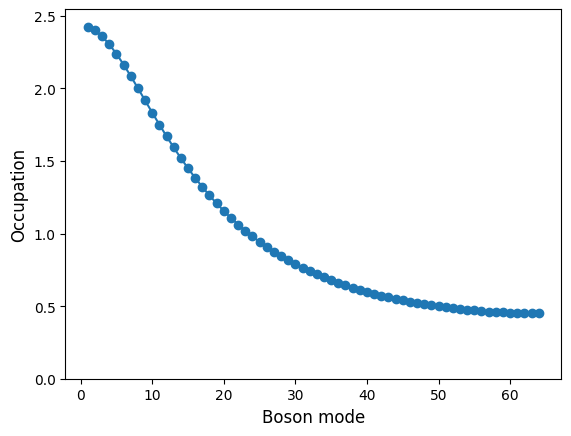

In [102]:
bosoncorr_eigvals = np.sort(np.linalg.eigvals(bosoncorr_mat))[::-1]
plt.plot(np.arange(1,L+1), bosoncorr_eigvals, marker='o')
plt.xlabel('Boson mode', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.yscale('linear')
plt.xscale('linear')
plt.ylim(0, 1.05*max(bosoncorr_eigvals))
plt.show()

## <font color='blue'>On-site number distribution</font>

### Calculate

In [103]:
start_time = time.time()

ndist = []
for i in range(L):
    site_dist = []
    for n in range(nmax+1):
        os = driver.expr_builder().add_term(proj_keys[n], [i], 1)
        op = driver.get_mpo(os.finalize())
        opexp = driver.expectation(mps, op, mps)
        site_dist.append(opexp)
    ndist.append(site_dist)
ndist = np.array(ndist)
print("Deviation from unit filling =", np.linalg.norm([ndist[i].sum()-1 for i in range(L)]))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Deviation from unit filling = 7.559338916863882e-14
Elapsed time: 13.345177173614502 seconds


### Site-averaged number distribution

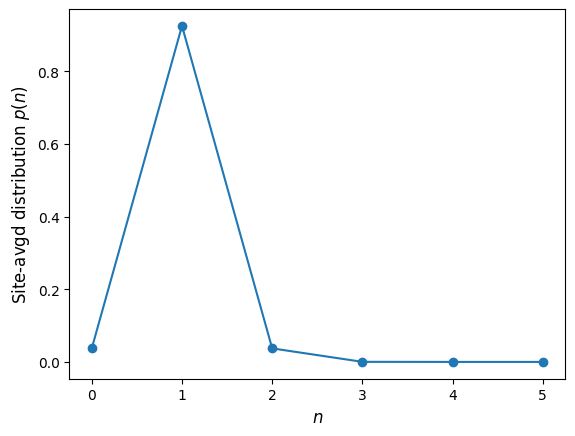

In [104]:
plt.plot(np.mean(ndist, axis=0), marker='o')
plt.xlabel('$n$', fontsize=12)
plt.ylabel('Site-avgd distribution $p(n)$', fontsize=12)
plt.yscale('linear')
plt.show()

### Number fluctuation

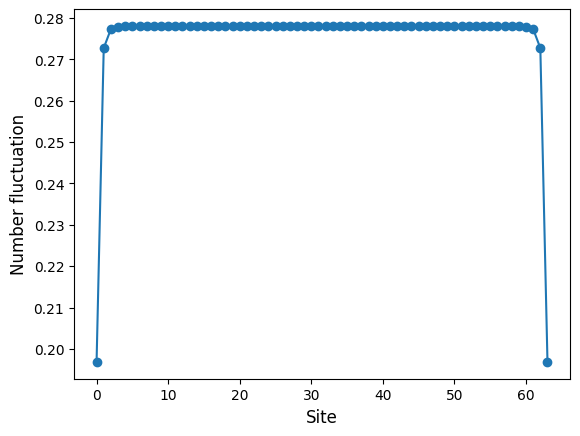

In [105]:
nsqavg = np.array([np.dot(np.arange(nmax+1)**2, ndist[i]) for i in range(L)])
numfluc = np.sqrt(nsqavg - navg*navg)
plt.plot(np.arange(L), numfluc, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Number fluctuation', fontsize=12)
plt.show()

## <font color='blue'>Density-density correlations</font>

### Calculate

In [106]:
start_time = time.time()

nnexp = []
for i in range(L):
    for j in range(i,L):
        os = driver.expr_builder().add_term("cdcd", [i, i, j, j], 1)
        op = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""))
        opexp = driver.expectation(mps, op, mps)
        nnexp.append(opexp)
nnexp_mat = vector_to_hermitian(nnexp)
densitycorr_mat = nnexp_mat - np.outer(navg, navg)
print("Avg number fluctuation =", np.mean(np.sqrt(np.diag(densitycorr_mat))))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Avg number fluctuation = 0.27530602421330663
Elapsed time: 71.59127616882324 seconds


### Correlation matrix

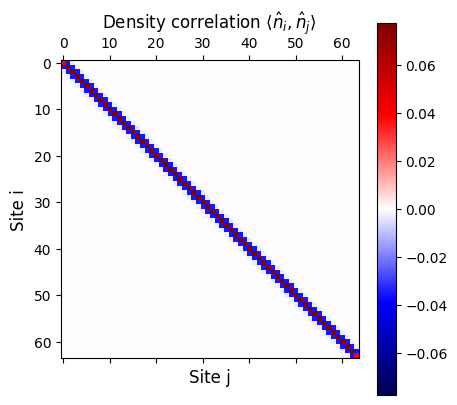

In [107]:
plt.matshow(densitycorr_mat, cmap='seismic', vmin=-np.abs(densitycorr_mat).max(), vmax=np.abs(densitycorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Density correlation $\langle \hat{n}_{i}, \hat{n}_{j} \rangle$')
plt.show()

### Correlation vs distance

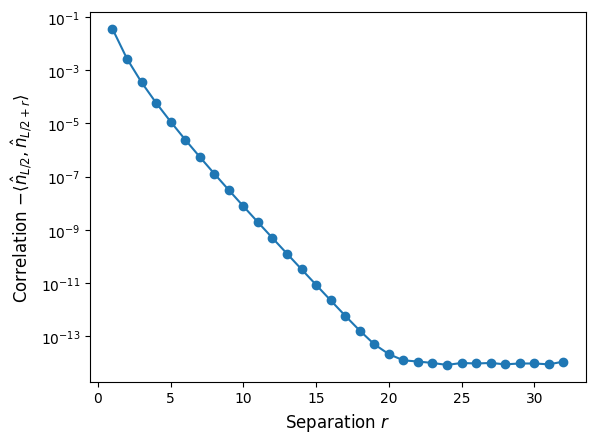

In [108]:
plt.plot(np.arange(1,L//2+1), -densitycorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $-\langle \hat{n}_{L/2}, \hat{n}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()

# <font color='red'>Boson with $U/t = 2$</font>

## <font color='blue'>Parameters</font>

In [109]:
L = 64
N = 64
t = 1.0
U = 2.0
nmax = 5

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

## <font color='blue'>Local operators</font>

In [110]:
# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

basis = [(Q(i), 1) for i in range(nmax + 1)]

bdag = np.diag([np.sqrt(n+1) for n in range(nmax)], -1)
b = bdag.T
ops = {
    "": np.identity(nmax + 1), 
    "c": bdag, 
    "d": b
}

#proj_keys = ["P"+str(n) for n in range(nmax+1)]
proj_keys = ["Q","R","S","T","U","V","W","X","Y"][:nmax+1]
proj_ops = []
for n in range(nmax+1):
    proj_diag = np.diag(np.repeat([0, 1., 0], [n, 1, nmax-n]))
    proj_ops.append(proj_diag)
proj_dict = {}
for n in range(nmax+1):
    proj_dict[proj_keys[n]] = proj_ops[n]

for k in range(L): 
    site_basis.append(basis)
    site_ops.append(ops | proj_dict)

## <font color='blue'>Hamiltonian</font>

In [111]:
# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0), target=Q(N), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
os = driver.expr_builder()

for i in range(L-1):
    os.add_term("cd", [i, i+1], -t)
    os.add_term("cd", [i+1, i], -t)
for i in range(L):
    os.add_term("ccdd", [i, i, i, i], U/2)

# [Part C] Perform DMRG
mpo = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)

## <font color='blue'>DMRG</font>

In [112]:
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=1, occs=[1] * L)
energy = driver.dmrg(
    mpo, 
    mps, 
    n_sweeps=100, 
    bond_dims=[50] * 10 + [100] * 5 + [200] * 5, # + [500] * 5 + [1000] * 5, 
    noises=[1e-3] * 3 + [1e-5] * 3 + [0],  
    thrds=[1e-10] * 20, 
    dav_max_iter=100, 
    tol=1e-10, 
    iprint=1)
print("Final bond dimension =", mps.info.get_max_bond_dimension())


Sweep =    0 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      0.504 | E =     -82.2402669899 | DW = 1.10434e-10

Sweep =    1 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      1.948 | E =     -83.9493181962 | DE = -1.71e+00 | DW = 1.26790e-08

Sweep =    2 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      4.139 | E =     -84.4744157471 | DE = -5.25e-01 | DW = 4.04061e-08

Sweep =    3 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      5.437 | E =     -84.6610545142 | DE = -1.87e-01 | DW = 2.14248e-08

Sweep =    4 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      7.317 | E =     -84.6915030665 | DE = -3.04e-02 | DW = 6.84708e-08

Sweep =    5 | Direction = backward 

## <font color='blue'>Evolution over sweeps</font>

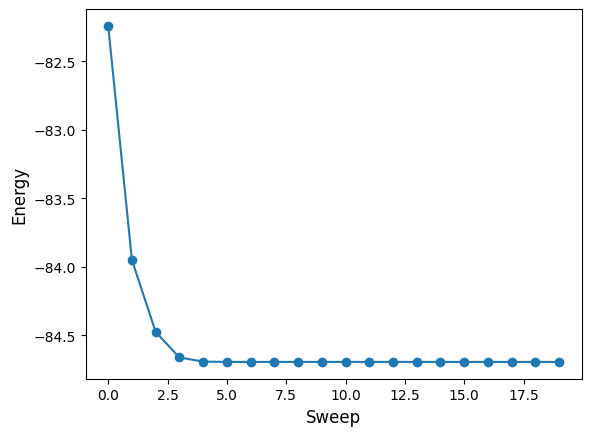

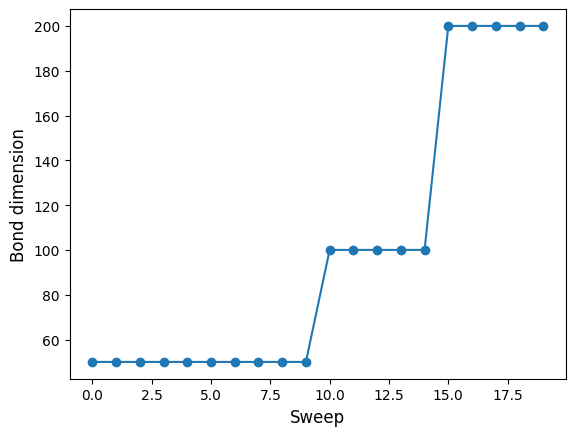

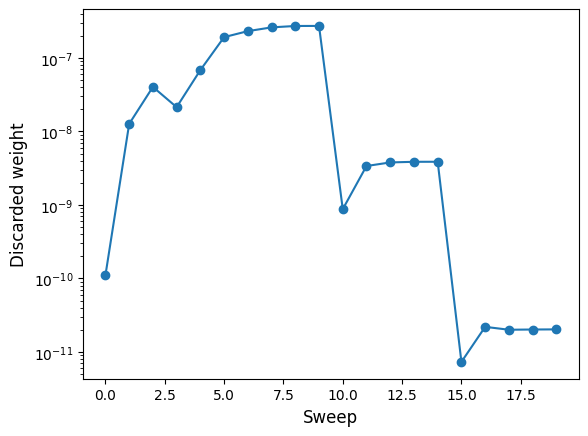

In [113]:
bonddims, discardedweights, energies = driver.get_dmrg_results()
plt.plot(energies.flatten(), marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.show()
plt.plot(bonddims, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Bond dimension', fontsize=12)
plt.show()
plt.plot(discardedweights, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Discarded weight', fontsize=12)
plt.yscale('log')
plt.show()

## <font color='blue'>Entanglement</font>

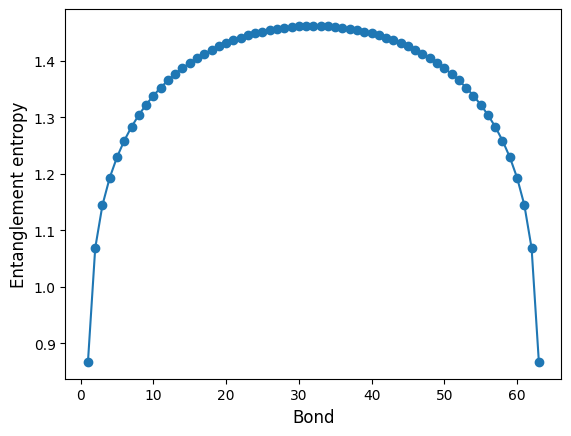

In [114]:
SvN = driver.get_bipartite_entanglement()

plt.plot(np.arange(1,L), SvN, marker='o')
plt.xlabel('Bond', fontsize=12)
plt.ylabel('Entanglement entropy', fontsize=12)
plt.show()

## <font color='blue'>Single-particle boson correlations</font>

### Calculate

In [115]:
start_time = time.time()

bosoncorr = []
for i in range(L):
    for j in range(i,L):
        os = driver.expr_builder().add_term("cd", [i, j], 1)
        op = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""))
        opexp = driver.expectation(mps, op, mps)
        bosoncorr.append(opexp)
bosoncorr_mat = vector_to_hermitian(bosoncorr)
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Total number = 64.00000000000013
Elapsed time: 126.8375039100647 seconds


### Site occupations

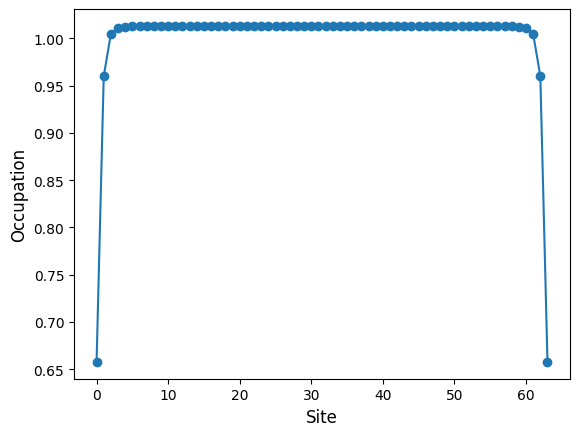

In [116]:
plt.plot(np.arange(L), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

### Correlation matrix

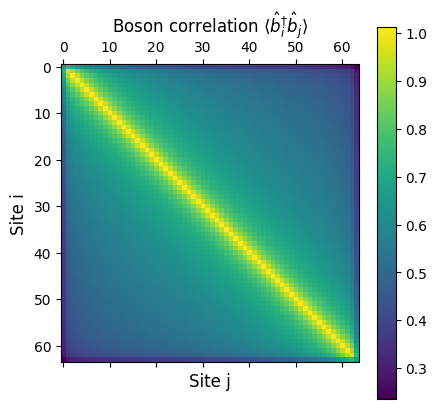

In [117]:
plt.matshow(bosoncorr_mat, cmap='viridis', vmin=bosoncorr_mat.min(), vmax=bosoncorr_mat.max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

### Correlation vs distance

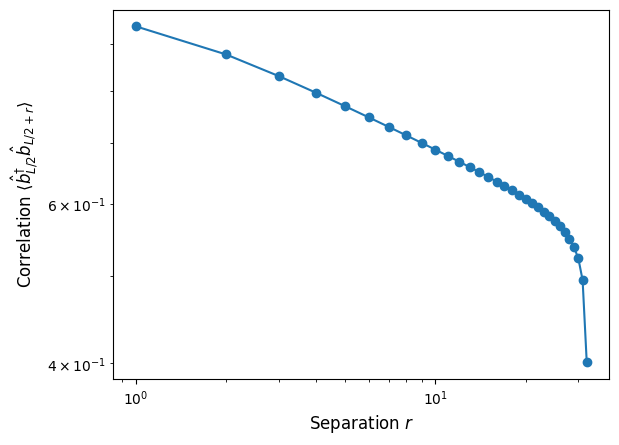

In [118]:
plt.plot(np.arange(1,L//2+1), bosoncorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.show()

### Momentum distribution

Total number = 64.0000000000001


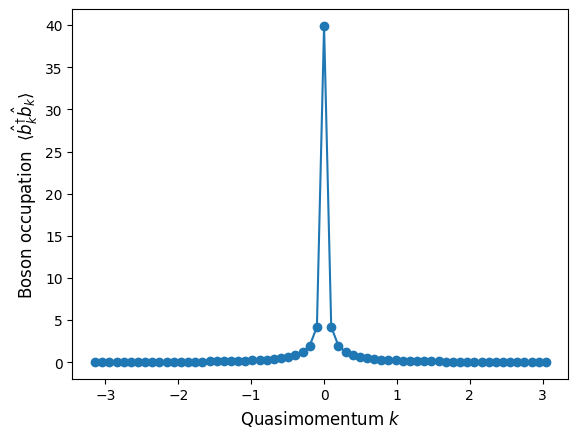

In [119]:
klist = (2*np.pi/L)*np.arange(-L//2,L//2)
fourier = np.array([[np.exp(1j*k*j) for j in np.arange(L)] for k in klist])
fourier_inverse = fourier.conj().T
boson_momentum_corr = np.dot(np.dot(fourier, bosoncorr_mat), fourier_inverse)/L
boson_momentum_dist = np.real(np.diag(boson_momentum_corr))
print("Total number =", sum(boson_momentum_dist))

plt.plot(klist, boson_momentum_dist, marker='o')
plt.xlabel('Quasimomentum $k$', fontsize=12)
plt.ylabel(r'Boson occupation  $\langle \hat{b}_k^{\dagger} \hat{b}_k \rangle$', fontsize=12)
plt.yscale('linear')
plt.xscale('linear')
#plt.ylim(0, 1.05*max(boson_momentum_dist))
plt.show()

### Single-particle modes

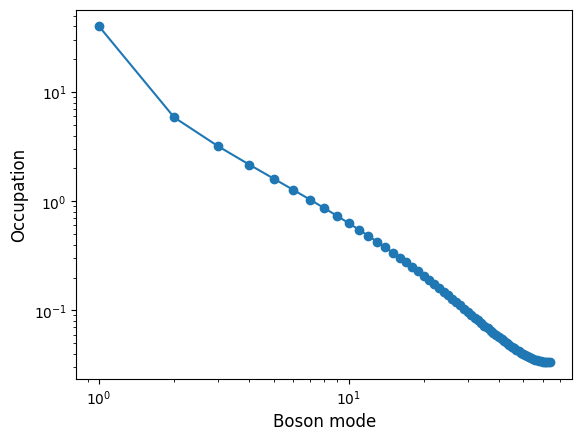

In [120]:
bosoncorr_eigvals = np.sort(np.linalg.eigvals(bosoncorr_mat))[::-1]
plt.plot(np.arange(1,L+1), bosoncorr_eigvals, marker='o')
plt.xlabel('Boson mode', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(0, 1.05*max(bosoncorr_eigvals))
plt.show()

## <font color='blue'>On-site number distribution</font>

### Calculate

In [121]:
start_time = time.time()

ndist = []
for i in range(L):
    site_dist = []
    for n in range(nmax+1):
        os = driver.expr_builder().add_term(proj_keys[n], [i], 1)
        op = driver.get_mpo(os.finalize())
        opexp = driver.expectation(mps, op, mps)
        site_dist.append(opexp)
    ndist.append(site_dist)
ndist = np.array(ndist)
print("Deviation from unit filling =", np.linalg.norm([ndist[i].sum()-1 for i in range(L)]))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Deviation from unit filling = 1.5681286149399935e-14
Elapsed time: 23.49614191055298 seconds


### Site-averaged number distribution

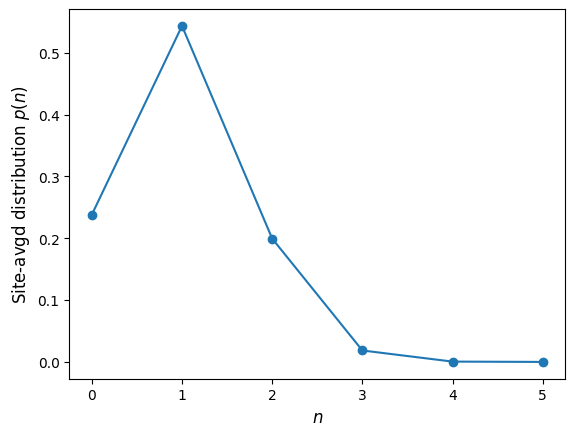

In [124]:
plt.plot(np.mean(ndist, axis=0), marker='o', label='Actual')
plt.xlabel('$n$', fontsize=12)
plt.ylabel('Site-avgd distribution $p(n)$', fontsize=12)
plt.yscale('linear')
#plt.plot([1/(np.e*math.factorial(n)) for n in range(nmax+1)], marker='o', label='Poisson')
#plt.legend()
plt.show()

### Number fluctuation

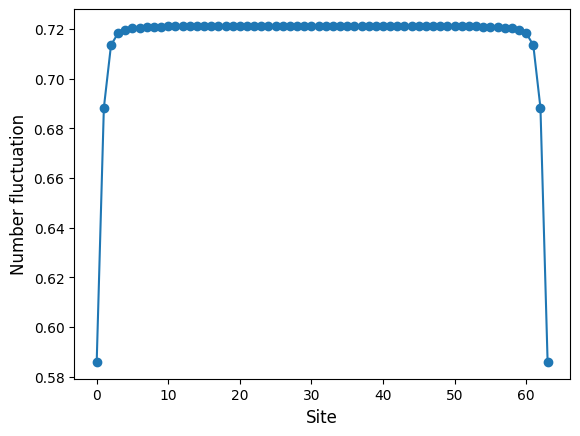

In [125]:
nsqavg = np.array([np.dot(np.arange(nmax+1)**2, ndist[i]) for i in range(L)])
numfluc = np.sqrt(nsqavg - navg*navg)
plt.plot(np.arange(L), numfluc, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Number fluctuation', fontsize=12)
plt.show()

## <font color='blue'>Density-density correlations</font>

### Calculate

In [126]:
start_time = time.time()

nnexp = []
for i in range(L):
    for j in range(i,L):
        os = driver.expr_builder().add_term("cdcd", [i, i, j, j], 1)
        op = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""))
        opexp = driver.expectation(mps, op, mps)
        nnexp.append(opexp)
nnexp_mat = vector_to_hermitian(nnexp)
densitycorr_mat = nnexp_mat - np.outer(navg, navg)
print("Avg number fluctuation =", np.mean(np.sqrt(np.diag(densitycorr_mat))))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Avg number fluctuation = 0.7155239154497557
Elapsed time: 127.48149704933167 seconds


### Correlation matrix

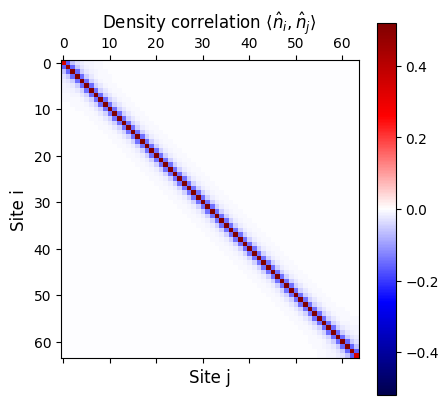

In [127]:
plt.matshow(densitycorr_mat, cmap='seismic', vmin=-np.abs(densitycorr_mat).max(), vmax=np.abs(densitycorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Density correlation $\langle \hat{n}_{i}, \hat{n}_{j} \rangle$')
plt.show()

### Correlation vs distance

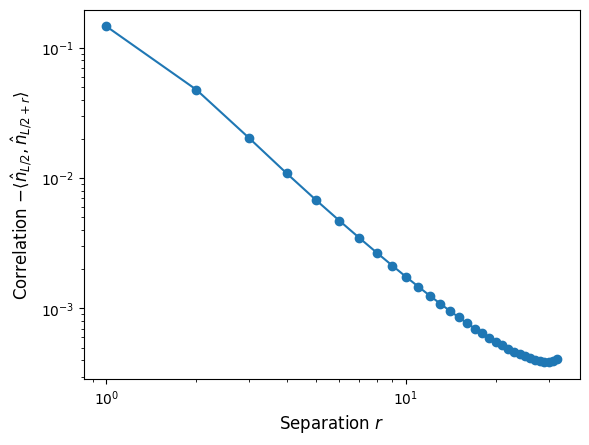

In [128]:
plt.plot(np.arange(1,L//2+1), -densitycorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $-\langle \hat{n}_{L/2}, \hat{n}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.show()

# <font color='red'>Pseudofermion with $U/t=2$</font>

## <font color='blue'>Parameters</font>

In [129]:
L = 64
N = 64
t = 1.0
U = 2.0
nmax = 5

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

## <font color='blue'>Local operators</font>

In [130]:
# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

basis = [(Q(i), 1) for i in range(nmax + 1)]

bdag = np.diag([np.sqrt(n+1) for n in range(nmax)], -1)
b = bdag.T
adag = np.diag([np.sqrt(n+1) * (-1)**n for n in range(nmax)], -1)
a = adag.T
parity = np.diag([(-1.)**n for n in range(nmax+1)])
ops = {
    "": np.identity(nmax + 1), 
    "c": bdag, 
    "d": b, 
    "C": adag, 
    "D": a, 
    "P": parity
}

#proj_keys = ["P"+str(n) for n in range(nmax+1)]
proj_keys = ["Q","R","S","T","U","V","W","X","Y"][:nmax+1]
proj_ops = []
for n in range(nmax+1):
    proj_diag = np.diag(np.repeat([0, 1., 0], [n, 1, nmax-n]))
    proj_ops.append(proj_diag)
proj_dict = {}
for n in range(nmax+1):
    proj_dict[proj_keys[n]] = proj_ops[n]

for k in range(L): 
    site_basis.append(basis)
    site_ops.append(ops | proj_dict)

## <font color='blue'>Hamiltonian</font>

In [131]:
# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0), target=Q(N), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
os = driver.expr_builder()

for i in range(L-1):
    os.add_term("Cd", [i, i+1], -t)
    os.add_term("cD", [i+1, i], -t)
for i in range(L):
    os.add_term("ccdd", [i, i, i, i], U/2)

# [Part C] Perform DMRG
mpo = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)

## <font color='blue'>DMRG</font>

In [132]:
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=1, occs=[1] * L)
energy = driver.dmrg(
    mpo, 
    mps, 
    n_sweeps=100, 
    bond_dims=[50] * 10 + [100] * 5 + [200] * 5, # + [500] * 5 + [1000] * 5, 
    noises=[1e-3] * 3 + [1e-5] * 3 + [0],  
    thrds=[1e-10] * 20, 
    dav_max_iter=100, 
    tol=1e-10, 
    iprint=1)
print("Final bond dimension =", mps.info.get_max_bond_dimension())


Sweep =    0 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      0.716 | E =     -51.2547370636 | DW = 1.89479e-08

Sweep =    1 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      4.797 | E =     -52.8028883157 | DE = -1.55e+00 | DW = 1.69524e-07

Sweep =    2 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      8.813 | E =     -53.7553861348 | DE = -9.52e-01 | DW = 5.56643e-07

Sweep =    3 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =     11.932 | E =     -54.5974637530 | DE = -8.42e-01 | DW = 3.31927e-07

Sweep =    4 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =     15.767 | E =     -54.6784865239 | DE = -8.10e-02 | DW = 6.03446e-07

Sweep =    5 | Direction = backward 

## <font color='blue'>Evolution over sweeps</font>

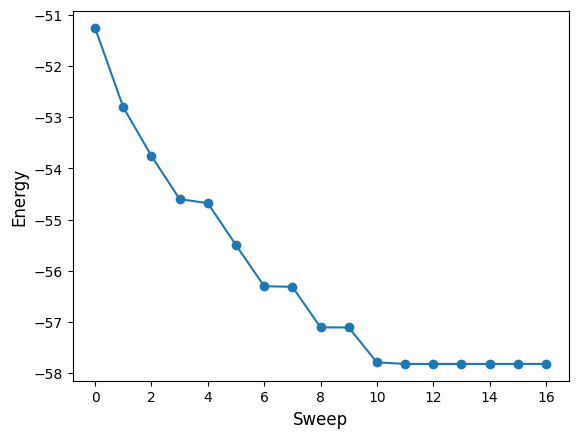

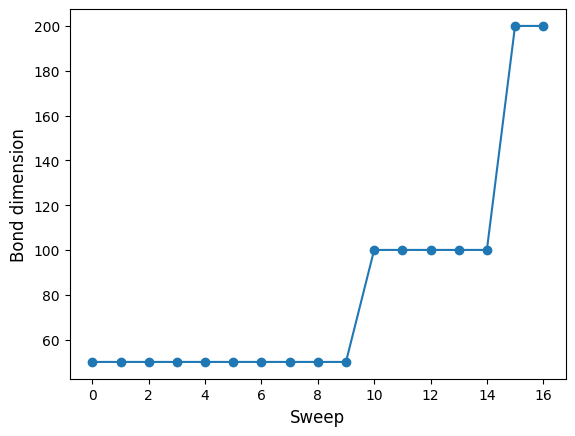

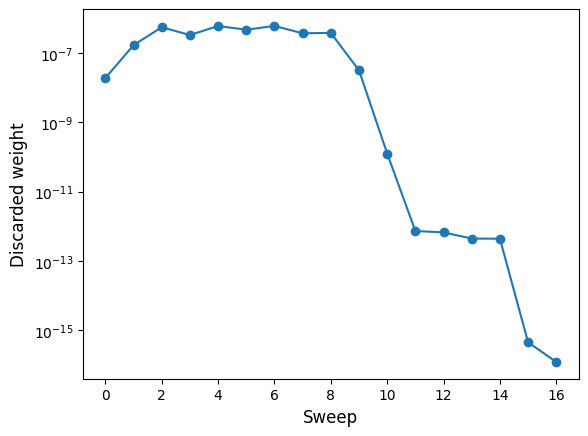

In [133]:
bonddims, discardedweights, energies = driver.get_dmrg_results()
plt.plot(energies.flatten(), marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.show()
plt.plot(bonddims, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Bond dimension', fontsize=12)
plt.show()
plt.plot(discardedweights, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Discarded weight', fontsize=12)
plt.yscale('log')
plt.show()

## <font color='blue'>Entanglement</font>

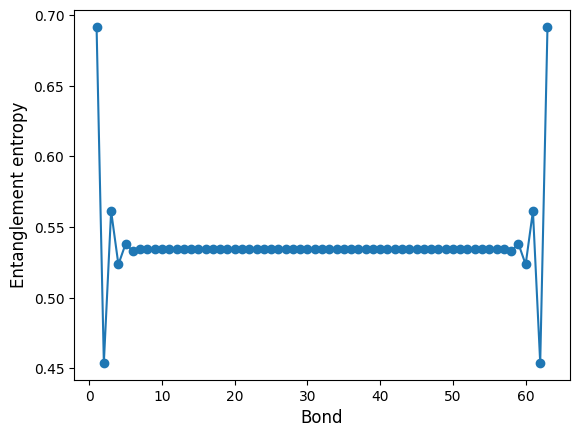

In [134]:
SvN = driver.get_bipartite_entanglement()

plt.plot(np.arange(1,L), SvN, marker='o')
plt.xlabel('Bond', fontsize=12)
plt.ylabel('Entanglement entropy', fontsize=12)
plt.show()

## <font color='blue'>Single-particle boson correlations</font>

### Calculate

In [135]:
start_time = time.time()

bosoncorr = []
for i in range(L):
    for j in range(i,L):
        os = driver.expr_builder().add_term("cd", [i, j], 1)
        op = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""))
        opexp = driver.expectation(mps, op, mps)
        bosoncorr.append(opexp)
bosoncorr_mat = vector_to_hermitian(bosoncorr)
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Total number = 64.00000000000003
Elapsed time: 130.1160271167755 seconds


### Site occupations

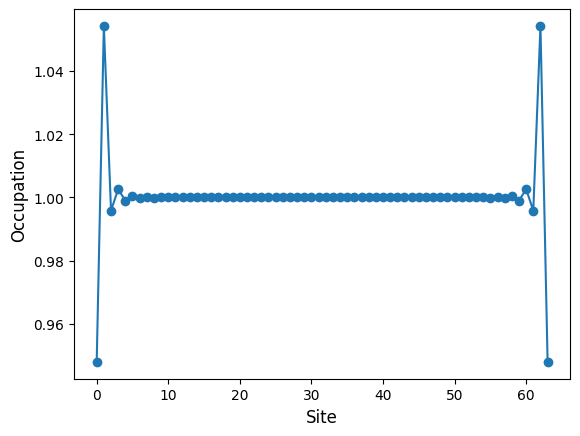

In [136]:
plt.plot(np.arange(L), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

### Correlation matrix

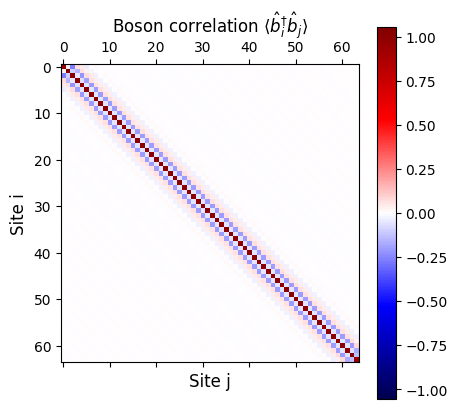

In [137]:
plt.matshow(bosoncorr_mat, cmap='seismic', vmin=-np.abs(bosoncorr_mat).max(), vmax=np.abs(bosoncorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

### Correlation vs distance

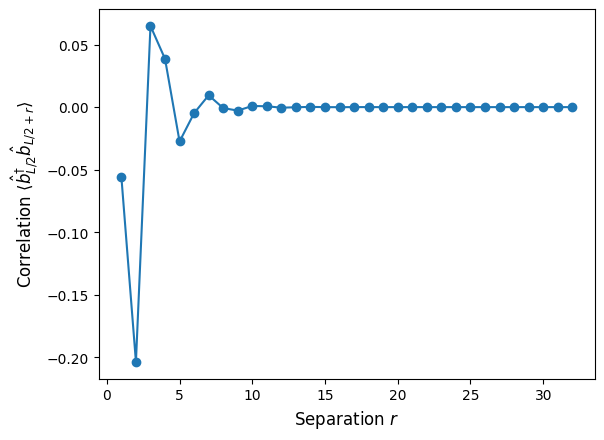

In [138]:
plt.plot(np.arange(1,L//2+1), bosoncorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.show()

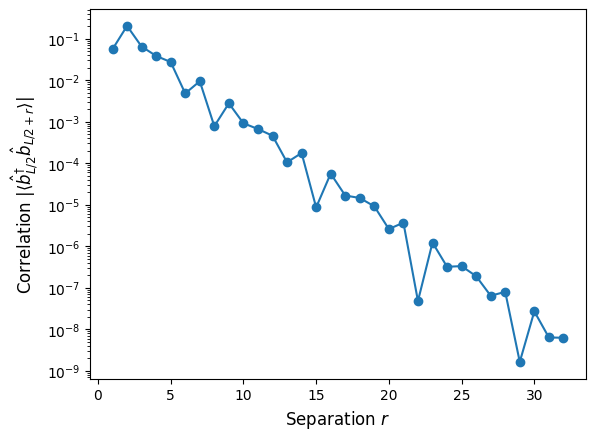

In [139]:
plt.plot(np.arange(1,L//2+1), abs(bosoncorr_mat[L//2-1,L//2:]), marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $|\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle|$', fontsize=12)
plt.yscale('log')
plt.show()

### Momentum distribution

Total number = 64.00000000000003


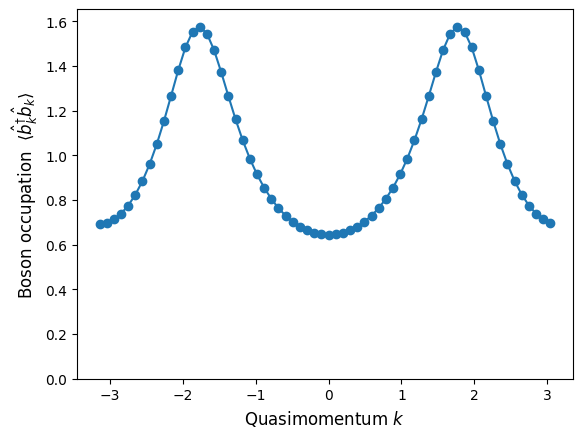

In [140]:
klist = (2*np.pi/L)*np.arange(-L//2,L//2)
fourier = np.array([[np.exp(1j*k*j) for j in np.arange(L)] for k in klist])
fourier_inverse = fourier.conj().T
boson_momentum_corr = np.dot(np.dot(fourier, bosoncorr_mat), fourier_inverse)/L
boson_momentum_dist = np.real(np.diag(boson_momentum_corr))
print("Total number =", sum(boson_momentum_dist))

plt.plot(klist, boson_momentum_dist, marker='o')
plt.xlabel('Quasimomentum $k$', fontsize=12)
plt.ylabel(r'Boson occupation  $\langle \hat{b}_k^{\dagger} \hat{b}_k \rangle$', fontsize=12)
plt.ylim(0, 1.05*max(boson_momentum_dist))
plt.show()

### Single-particle modes

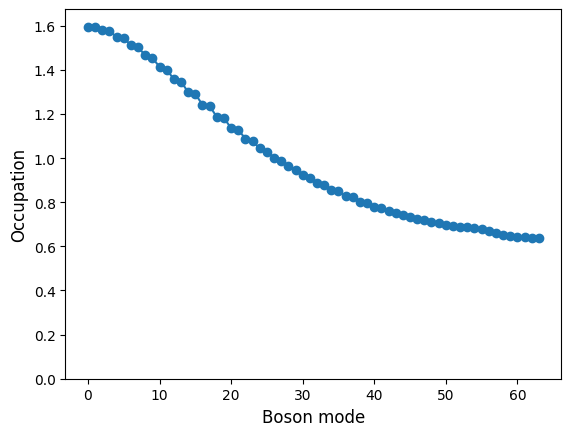

In [141]:
bosoncorr_eigvals = np.sort(np.linalg.eigvals(bosoncorr_mat))[::-1]
plt.plot(bosoncorr_eigvals, marker='o')
plt.xlabel('Boson mode', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.ylim(0, 1.05*max(bosoncorr_eigvals))
plt.yscale('linear')
plt.show()

## <font color='blue'>Single-particle anyon correlations</font>

### Calculate

In [142]:
start_time = time.time()

anyoncorr = []
for i in range(L):
    for j in range(i,L):
        os = driver.expr_builder().add_term("c"+"".join(["P"]*(j-i))+"d", [i] + list(range(i,j+1)), 1)
        op = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""))
        opexp = driver.expectation(mps, op, mps)
        anyoncorr.append(opexp)
anyoncorr_mat = vector_to_hermitian(anyoncorr)
print("Site occupation mismatch =", np.linalg.norm(navg - np.diag(anyoncorr_mat)))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Site occupation mismatch = 0.0
Elapsed time: 129.88401222229004 seconds


### Correlation matrix

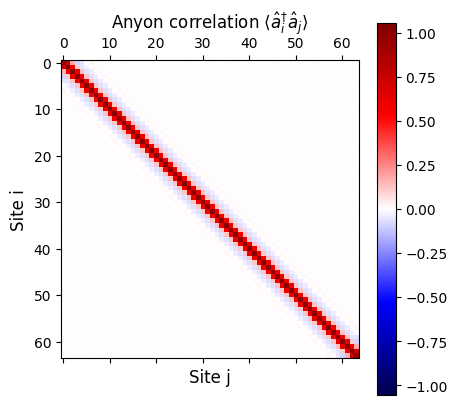

In [143]:
plt.matshow(anyoncorr_mat, cmap='seismic', vmin=-np.abs(anyoncorr_mat).max(), vmax=np.abs(anyoncorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Anyon correlation $\langle \hat{a}_{i}^{\dagger} \hat{a}_{j} \rangle$')
plt.show()

### Correlation vs distance

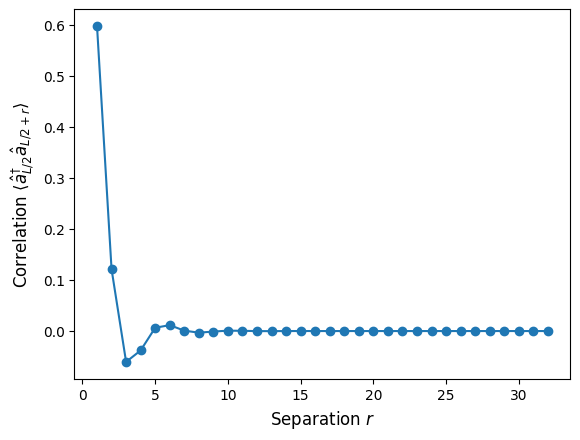

In [144]:
plt.plot(np.arange(1,L//2+1), anyoncorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{a}_{L/2}^{\dagger} \hat{a}_{L/2+r} \rangle$', fontsize=12)
plt.show()

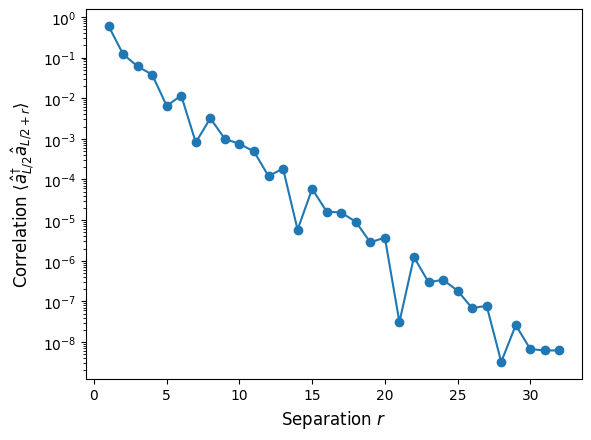

In [145]:
plt.plot(np.arange(1,L//2+1), abs(anyoncorr_mat[L//2-1,L//2:]), marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{a}_{L/2}^{\dagger} \hat{a}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.show()

### Momentum distribution

Total number = 64.00000000000003


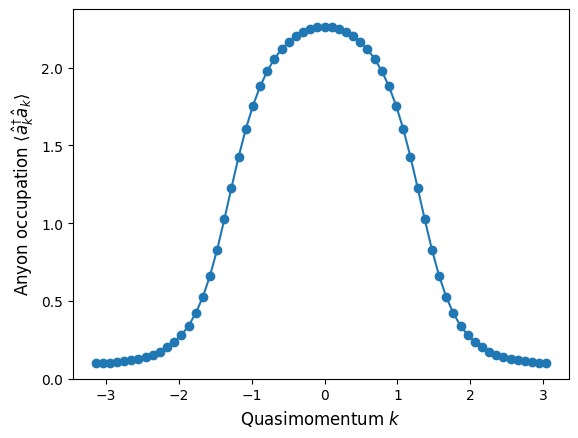

In [146]:
klist = (2*np.pi/L)*np.arange(-L//2,L//2)
fourier = np.array([[np.exp(1j*k*j) for j in np.arange(L)] for k in klist])
fourier_inverse = fourier.conj().T
anyon_momentum_corr = np.dot(np.dot(fourier, anyoncorr_mat), fourier_inverse)/L
anyon_momentum_dist = np.real(np.diag(anyon_momentum_corr))
print("Total number =", sum(anyon_momentum_dist))

plt.plot(klist, anyon_momentum_dist, marker='o')
plt.xlabel('Quasimomentum $k$', fontsize=12)
plt.ylabel(r'Anyon occupation $\langle \hat{a}_k^{\dagger} \hat{a}_k \rangle$', fontsize=12)
plt.ylim(0, 1.05*max(anyon_momentum_dist))
plt.show()

### Single-particle modes

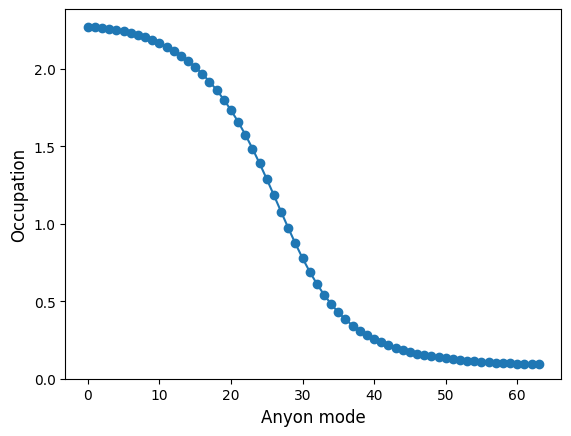

In [147]:
anyoncorr_eigvals = np.sort(np.linalg.eigvals(anyoncorr_mat))[::-1]
plt.plot(anyoncorr_eigvals, marker='o')
plt.xlabel('Anyon mode', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.ylim(0, 1.05*max(anyoncorr_eigvals))
plt.yscale('linear')
plt.show()

## <font color='blue'>On-site number distribution</font>

### Calculate

In [148]:
start_time = time.time()

ndist = []
for i in range(L):
    site_dist = []
    for n in range(nmax+1):
        os = driver.expr_builder().add_term(proj_keys[n], [i], 1)
        op = driver.get_mpo(os.finalize())
        opexp = driver.expectation(mps, op, mps)
        site_dist.append(opexp)
    ndist.append(site_dist)
ndist = np.array(ndist)
print("Deviation from unit filling =", np.linalg.norm([ndist[i].sum()-1 for i in range(L)]))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Deviation from unit filling = 1.2715810381844299e-14
Elapsed time: 24.810497999191284 seconds


### Site-averaged number distribution

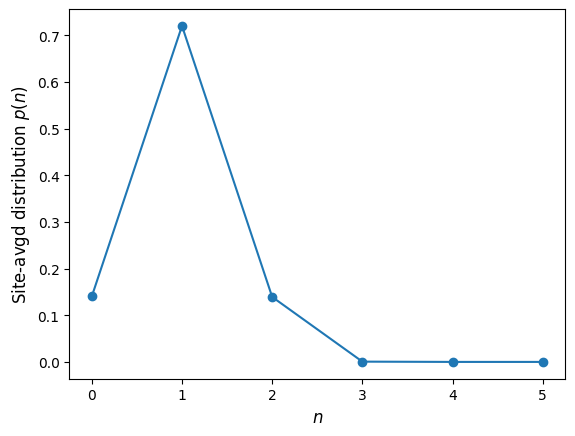

In [149]:
plt.plot(np.mean(ndist, axis=0), marker='o')
plt.xlabel('$n$', fontsize=12)
plt.ylabel('Site-avgd distribution $p(n)$', fontsize=12)
plt.yscale('linear')
plt.show()

### Number fluctuations

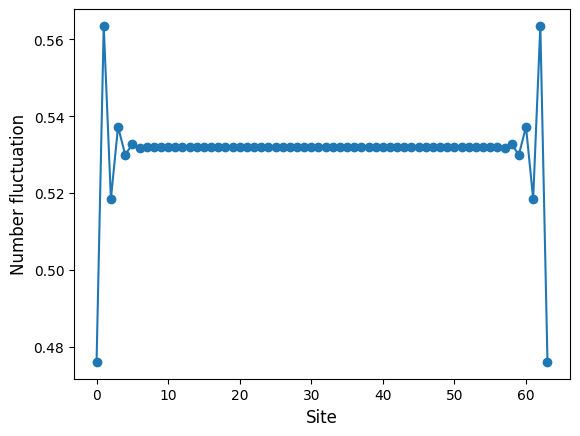

In [150]:
nsqavg = np.array([np.dot(np.arange(nmax+1)**2, ndist[i]) for i in range(L)])
numfluc = np.sqrt(nsqavg - navg*navg)
plt.plot(np.arange(L), numfluc, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Number fluctuation', fontsize=12)
plt.show()

## <font color='blue'>Density-density correlations</font>

### Calculate

In [151]:
start_time = time.time()

nnexp = []
for i in range(L):
    for j in range(i,L):
        os = driver.expr_builder().add_term("cdcd", [i, i, j, j], 1)
        op = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""))
        opexp = driver.expectation(mps, op, mps)
        nnexp.append(opexp)
nnexp_mat = vector_to_hermitian(nnexp)
densitycorr_mat = nnexp_mat - np.outer(navg, navg)
print("Avg number fluctuation =", np.mean(np.sqrt(np.diag(densitycorr_mat))))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Avg number fluctuation = 0.530907311060227
Elapsed time: 133.91336679458618 seconds


### Correlation matrix

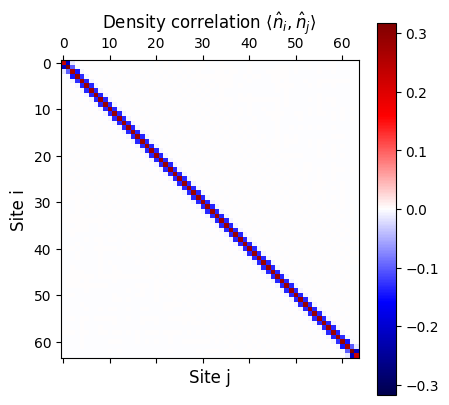

In [152]:
plt.matshow(densitycorr_mat, cmap='seismic', vmin=-np.abs(densitycorr_mat).max(), vmax=np.abs(densitycorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Density correlation $\langle \hat{n}_{i}, \hat{n}_{j} \rangle$')
plt.show()

### Correlation vs distance

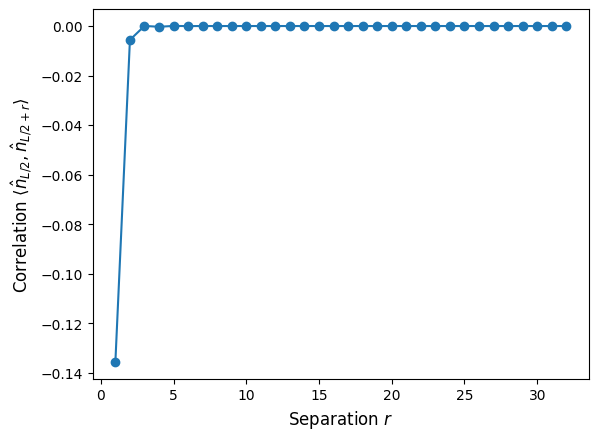

In [153]:
plt.plot(np.arange(1,L//2+1), densitycorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{n}_{L/2}, \hat{n}_{L/2+r} \rangle$', fontsize=12)
plt.show()

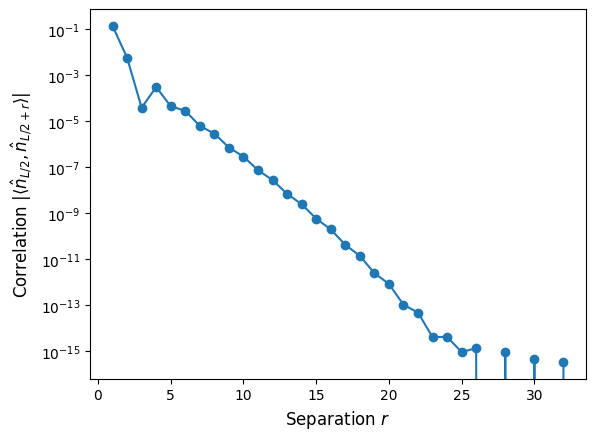

In [155]:
plt.plot(np.arange(1,L//2+1), abs(densitycorr_mat[L//2-1,L//2:]), marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $|\langle \hat{n}_{L/2}, \hat{n}_{L/2+r} \rangle|$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()